# Zimtohrli

Zimtohrli is a perceptual audio similarity metric intended to provide a simple scalar value representing the intensity of the human-perceptible difference between two sounds.

It is currently implemented in a Python/JAX version, and an SIMD vectorized C++ version.

The C++ version includes a command line tool to both compute norm-like distance scores based on provided distortions, and visually inspect and compare distortions to originals.

This Colab will present how it works and what the justification of the technical choices are using the Python/JAX implementation of Zimtohrli to display the individual layers it uses to model human hearing.

In [1]:
# @title Import necessary packages

from IPython.display import Markdown, display
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy

# E.g. CITC_CLIENT = 'my_citc_client_name'
CITC_CLIENT = None

if CITC_CLIENT:
  from importlib import reload
  from colabtools import adhoc_import
  with adhoc_import.Google3CitcClient(CITC_CLIENT):
    from google3.third_party.zimtohrli.python import signal
    signal = reload(signal)
    from google3.third_party.zimtohrli.python import loudness
    loudness = reload(loudness)
    from google3.third_party.zimtohrli.python import cam
    cam = reload(cam)
    from google3.third_party.zimtohrli.python import masking
    masking = reload(masking)
    from google3.third_party.zimtohrli.python import zimtohrli
    zimtohrli = reload(zimtohrli)
else:
  from colabtools import adhoc_import
  with adhoc_import.Google3SubmittedChangelist():
    from google3.third_party.zimtohrli.python import signal
    from google3.third_party.zimtohrli.python import loudness
    from google3.third_party.zimtohrli.python import cam
    from google3.third_party.zimtohrli.python import masking
    from google3.third_party.zimtohrli.python import zimtohrli


## Filterbank

To model human frequency resolution, the first layer of Zimtohrli implements a filterbank of simple elliptic band pass filters.

The choice of a filterbank instead of an integral transform such as DFT is motivated mainly by filter activation speed and ring duration depending on filter order and bandwidth instead of DFT window size.

This makes each filter in the bank activate as gradually and fast, and ring for as long, as is reasonable for that frequency and bandwith, instead of depending on the window size of an FFT that is likely applied equally for multiple channels.

To demonstrate how this is done, let's begin by constructing an example sound that will show us how the filtering performs.

We will use an exponential chirp, since will be easy to use to demonstrate the response in both the low and high frequency range.

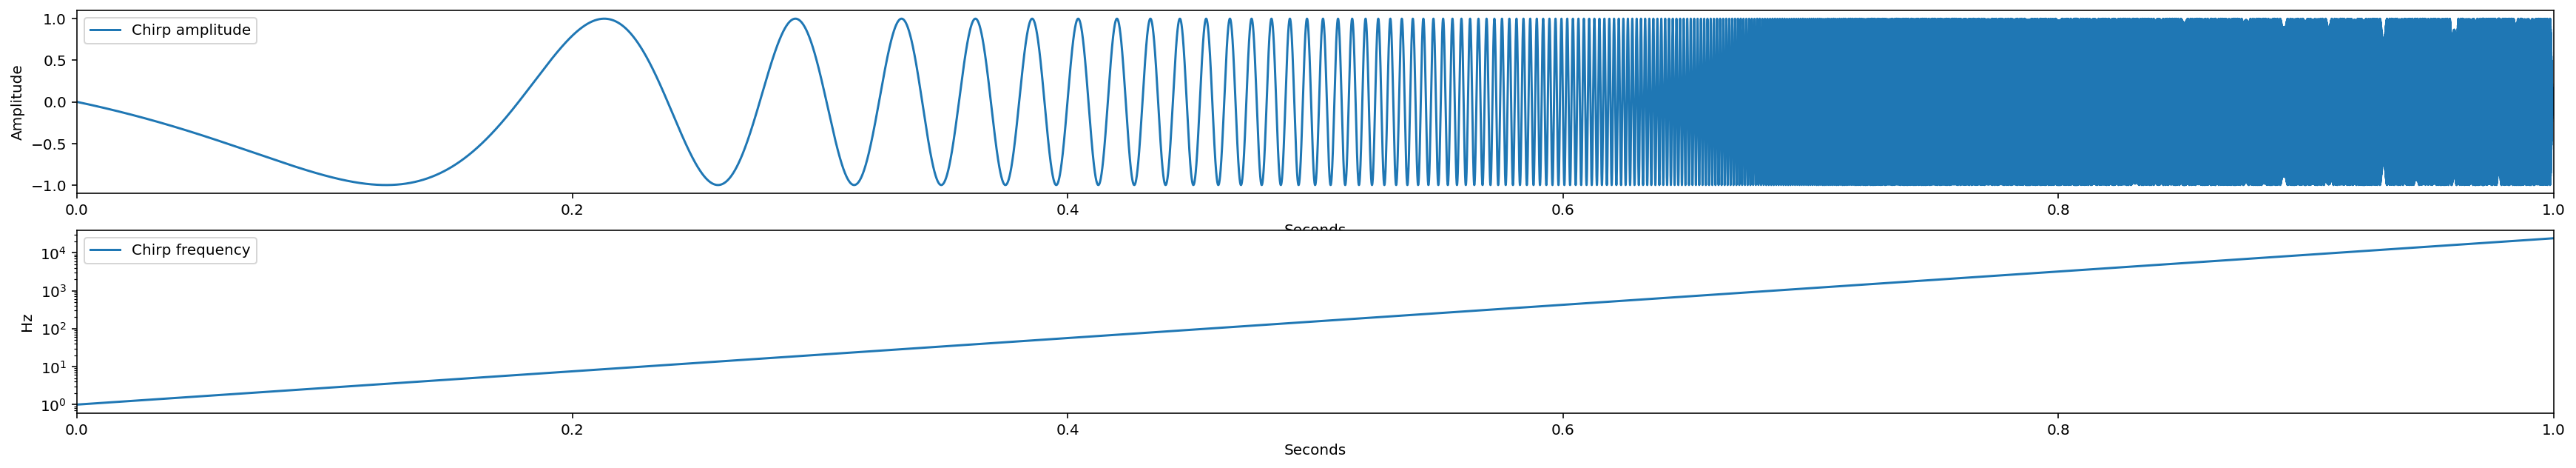

In [2]:
#@title Generate an exponential chirp and plot it's amplitude and frequency over time

sample_rate = 48000.0
chirp_sample_times = jnp.linspace(0.0, 1.0, int(sample_rate))
f0 = 1
f1 = sample_rate / 2
t1 = 1
chirp_freqz = f0 * (f1 / f0) ** (chirp_sample_times / t1)
chirp = signal.Signal(
    sample_rate=sample_rate,
    samples=scipy.signal.chirp(chirp_sample_times, f0, t1, f1, method='logarithmic', phi=90),
)
_, (chirp_ax, chirp_freqz_ax) = plt.subplots(
    2,
    1,
    figsize=(30, 5),
)

chirp_ax.plot(chirp_sample_times, chirp.samples, label='Chirp amplitude')
chirp_ax.set_ylabel('Amplitude')
chirp_ax.set_xlabel('Seconds')
chirp_ax.set_xlim((0, chirp.samples.shape[0] / chirp.sample_rate))
chirp_ax.legend()

chirp_freqz_ax.plot(chirp_sample_times, chirp_freqz, label='Chirp frequency')
chirp_freqz_ax.set_ylabel('Hz')
chirp_freqz_ax.set_xlabel('Seconds')
chirp_freqz_ax.set_yscale('log')
chirp_freqz_ax.set_xlim((0, chirp.samples.shape[0] / chirp.sample_rate))
chirp_freqz_ax.legend()

plt.show()

The filter used is a first order elliptic filter, as described by [scipy.signal.ellip](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ellip.html), with a passband ripple of 3dB. The stopband ripple parameter doesn't have an effect for first order elliptic filters in the [scipy source](https://github.com/scipy/scipy/blob/v1.11.4/scipy/signal/_filter_design.py#L3335-L3457), and is thus ignored here. This filter isn't very sharp, but reacts quickly.

Creating a bank of these elliptic filters so that they overlap at the 3dB attenuation edges of the passband, with an even width in [ERB](https://en.wikipedia.org/wiki/Equivalent_rectangular_bandwidth), provides a number of channels that should represent perceptually equally wide frequency bands.

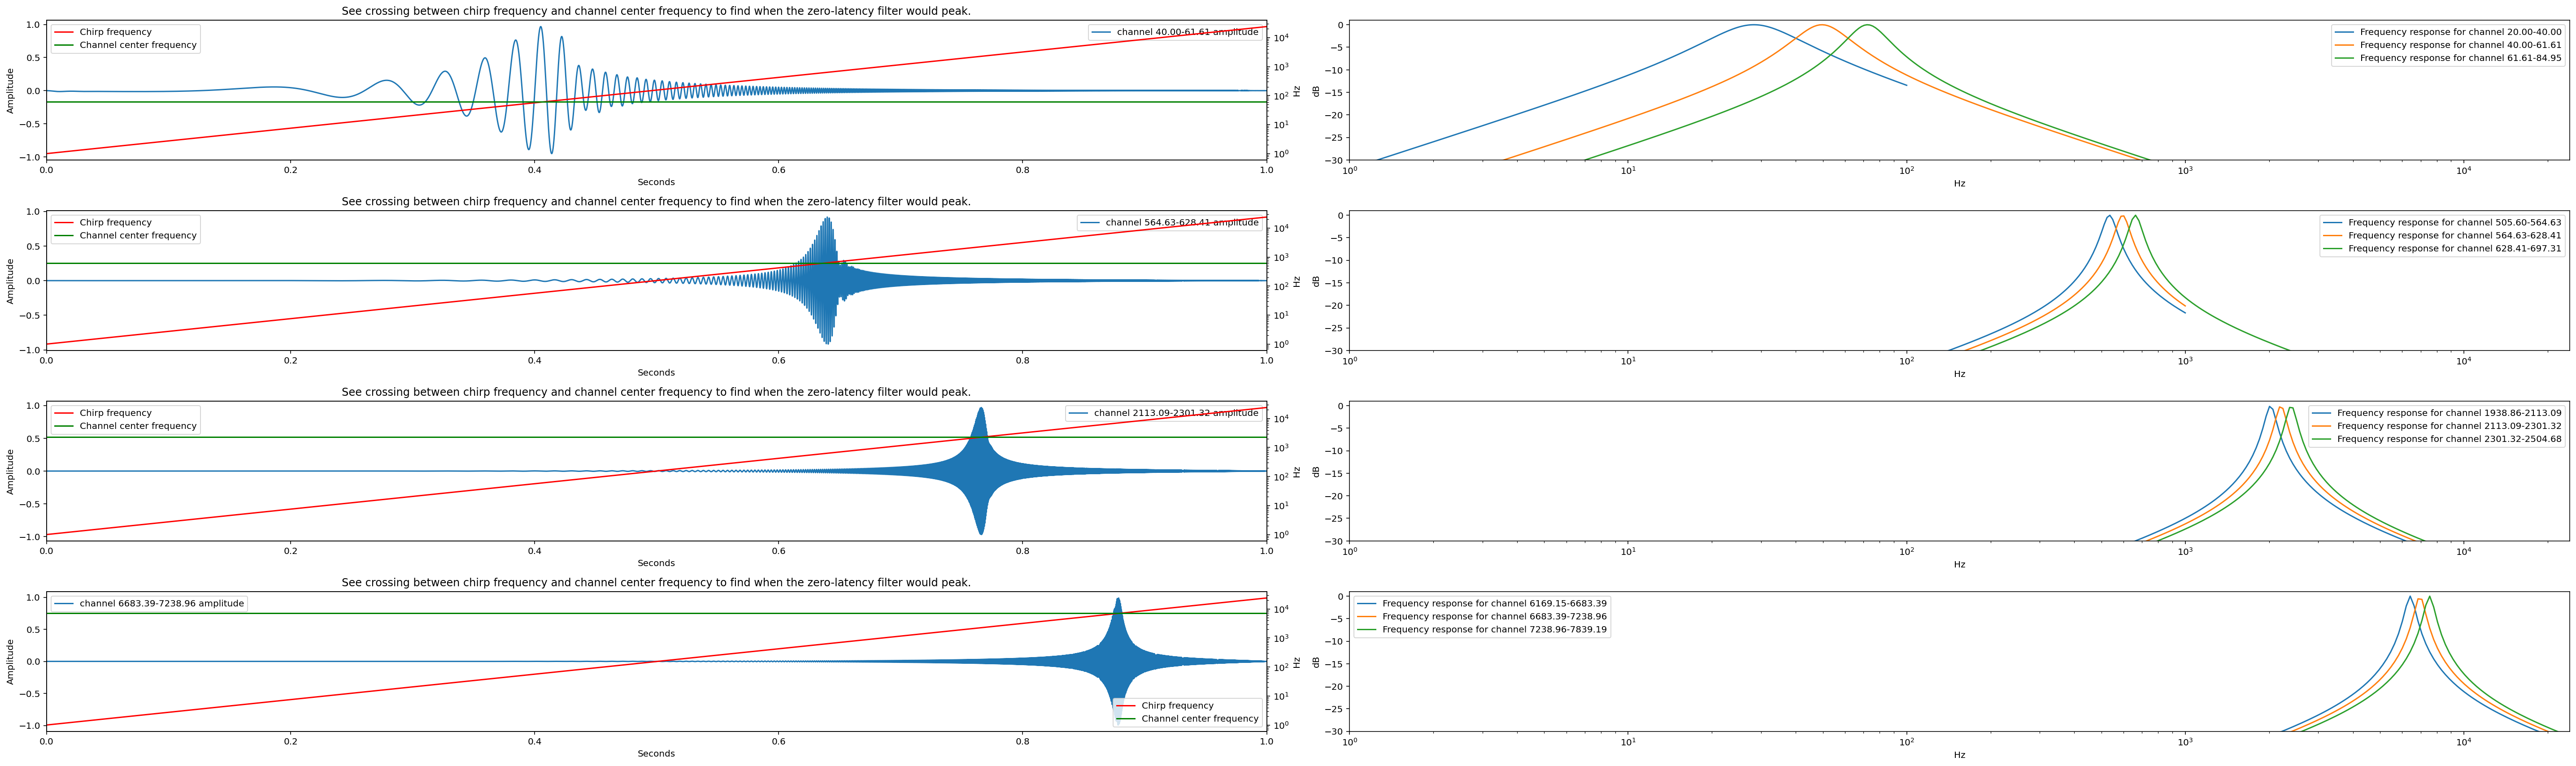

In [3]:
# @title Plot some channels of chirp filtered by bank with 10Hz resolution at narrowest filter
c = cam.Cam(minimum_channel_width_hz=20)
channels = c.channel_filter(chirp)
channels_to_plot = 4
_, ax = plt.subplots(
    channels_to_plot,
    2,
    figsize=(40, 3 * channels_to_plot),
)
channel_step = channels.samples.shape[0] // channels_to_plot
for ax_index in range(channels_to_plot):
  channel_index = ax_index * channel_step + 1
  ax[ax_index][0].plot(
      chirp_sample_times,
      channels.samples[channel_index],
      label=(
          'channel'
          f' {channels.freqs[channel_index, 0]:.2f}-{channels.freqs[channel_index, 1]:.2f} amplitude'
      ),
  )
  ax[ax_index][0].set_ylabel('Amplitude')
  ax[ax_index][0].set_xlabel('Seconds')
  ax[ax_index][0].set_xlim((0, chirp.samples.shape[0] / chirp.sample_rate))
  ax[ax_index][0].legend()
  ax[ax_index][0].set_title('See crossing between chirp frequency and channel center frequency to find when the zero-latency filter would peak.')
  ax2 = ax[ax_index][0].twinx()
  ax2.plot(chirp_sample_times, chirp_freqz, 'r', label='Chirp frequency')
  ax2.plot([jnp.min(chirp_sample_times), jnp.max(chirp_sample_times)], [channels.freqs[channel_index, 1], channels.freqs[channel_index, 1]], 'g', label='Channel center frequency')
  ax2.set_yscale('log')
  ax2.set_ylabel('Hz')
  ax2.legend()

  def plot_filter(channel_index):
    ba = scipy.signal.ellip(
        N=c.elliptic_order,
        rp=c.elliptic_ripple_pass,
        rs=c.elliptic_ripple_stop,
        Wn=(channels.freqs[channel_index, 0], channels.freqs[channel_index, 1]),
        btype='bandpass',
        analog=True,
        output='ba',
        fs=None,
    )
    w, h = scipy.signal.freqs(*ba, worN=500)
    ax[ax_index][1].plot(
        w,
        20 * jnp.log10(jnp.abs(h)),
        label=(
            'Frequency response for channel'
            f' {channels.freqs[channel_index, 0]:.2f}-{channels.freqs[channel_index, 1]:.2f}'
        ),
    )
  plot_filter(channel_index-1)
  plot_filter(channel_index)
  plot_filter(channel_index+1)
  ax[ax_index][1].set_ylabel('dB')
  ax[ax_index][1].set_xlabel('Hz')
  ax[ax_index][1].set_xscale('log')
  ax[ax_index][1].set_xlim((1, sample_rate * 0.5))
  ax[ax_index][1].set_ylim((-30, 1))
  ax[ax_index][1].legend()

plt.tight_layout()
plt.show()

These sample channels are then converted to energy channels by squaring the sample values and summing them over 10ms windows for downsampling to 100Hz, to approximate human temporal resolution of sound events.

## Masking model

After splitting the input signal into 100Hz energy channels Zimtohrli applies a masking model on the channels.

The masking model computes the perceptible energy in each channel loosely based on [Auditory Masking and its Effect on our Perception of Sound](https://blogs.qsc.com/live-sound/auditory-masking-and-its-effect-on-our-perception-of-sound/), [Auditory Time-Frequency Masking: Psychoacoustical Data and Application to Audio Representations](https://www.researchgate.net/figure/Results-of-Experiment-1-amount-of-masking-in-dB-as-a-function-of-F-in-ERB-units_fig1_258259835), [Auditory Time-Frequency Masking for Spectrally and Temporally Maximally-Compact Stimuli](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0166937), and our own experiments.

### Max energy of fully masked probe

The first step of the model is to compute the fully masked energy between each combination of two channels, as masker and probe. To do this, the fully masked energy of a probe a given distance in [ERB](https://en.wikipedia.org/wiki/Equivalent_rectangular_bandwidth) from the masker and masker energy is computed using a piecewise linear approximation.

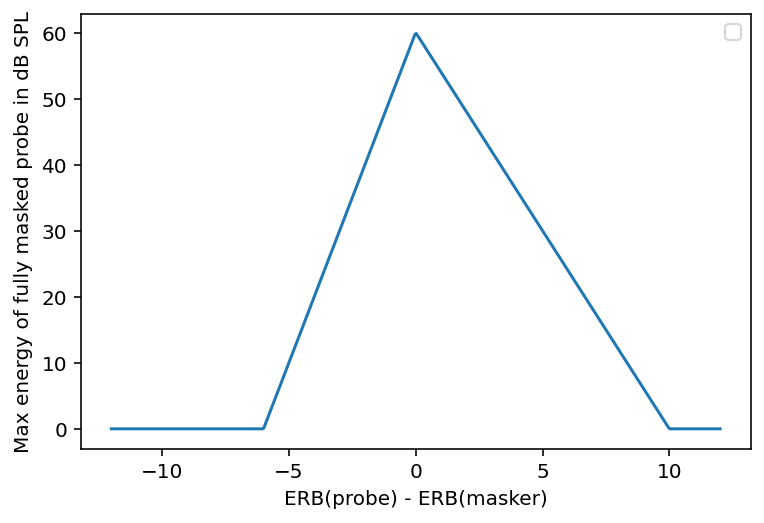

In [4]:
# @title Fully masked energy with 80dB SPL masker
m = masking.Masking()
cam_delta = jnp.linspace(-12, 12, 500)
plt.plot(
    cam_delta,
    m.full_masking(cam_delta, 80),
)
plt.ylabel('Max energy of fully masked probe in dB SPL')
plt.xlabel('ERB(probe) - ERB(masker)')
plt.legend()
plt.show()

### Masked amount of audible probe

To approximate the audible energy of an audible probe, i.e. a probe with more energy than **max energy of fully masked probe**, another piecewise linear function based on our experiments is used.

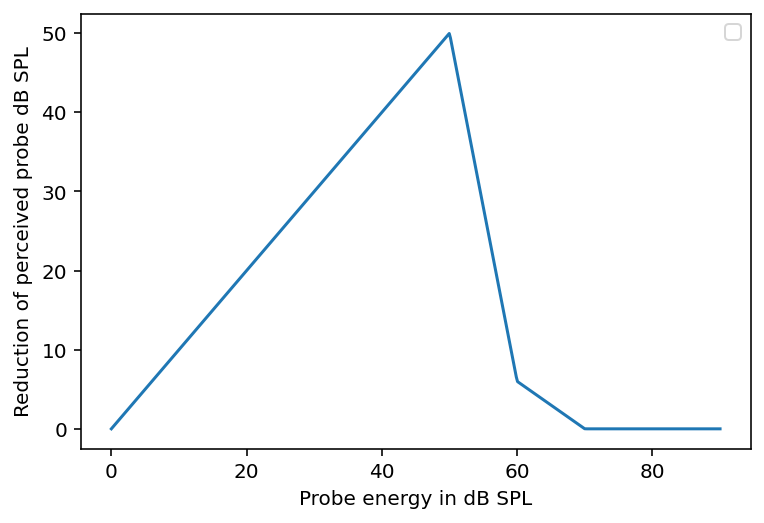

In [5]:
# @title Reduction of perceived probe db SPL with full masking at 50 dB SPL
m = masking.Masking()
probe_energy = jnp.linspace(0, 90, 500)
plt.plot(
    probe_energy,
    jnp.minimum(probe_energy, m.masked_amount(50, probe_energy)),
)
plt.ylabel('Reduction of perceived probe dB SPL')
plt.xlabel('Probe energy in dB SPL')
plt.legend()
plt.show()

### Masked amount of probe masked by multiple maskers

To simplity further discussion, let's first define some common terms:

|Term|Definition|
|----|----------|
|probe|Component of interest in a sound.|
|masking|When a component of a sound would be experienced as more intense when listened to in isolation.|
|masker|Component of a sound that, when added to the sound, causes masking.|
|partial energy|The energy in W/m<sup>2</sup> of an isolated version of the component amplified to be experienced equally intensely as when listened to as a component outside isolation.|
|partial dB|Partial energy in dB SPL.|
|masked amount|The difference in W/m<sup>2</sup> between the masked component and its partial energy.|
|masked dB|The partial dB subtracted from the dB SPL of the component.|

Performing a simple experiment where we have 5 separate components

- 1000 Hz sine probe 57 dB SPL
- 750 Hz sine masker A at 71dB SPL
- 800 Hz sine masker B at 71 dB SPL
- 850 Hz sine masker C at 67 dB SPL
- 900 Hz sine masker D at 65 dB SPL

I record the following data

- When playing probe + masker A through D individually I experience the probe approximately as intensely as a 1000Hz tone at 53dB SPL.
- When playing probe + all maskers I experience the probe approximately as intensely as a 1000Hz tone at 48dB SPL.

In [6]:
#@title Trying different ways to combine these numbers {display-mode: "form"}
reference_nw_per_sq_m_at_0_db = 1e-3  # See https://sengpielaudio.com/calculator-soundlevel.htm
nwm2 = 'nW/m<sup>2</sup>'

def db2e(x):
  return 10 ** (x * 0.1) * reference_nw_per_sq_m_at_0_db

def e2db(x):
  10 * jnp.log10(x / reference_nw_per_sq_m_at_0_db)

probe_db = 57
probe_energy = db2e(probe_db)
display(Markdown(f'Probe: {probe_db} dB SPL = {probe_energy:.2f} {nwm2}'))

individual_masker_partial_db = 53
individual_masker_partial_energy = db2e(individual_masker_partial_db)
display(Markdown(f'Probe after masking by each masker in isolation: {individual_masker_partial_db} dB SPL = {individual_masker_partial_energy:.2f} {nwm2}'))

masked_energy_per_masker = probe_energy - individual_masker_partial_energy
display(Markdown(f'Masked energy per masker: {probe_energy:.2f} - {individual_masker_partial_energy:.2f} = {masked_energy_per_masker:.2f} {nwm2}'))

sum_masked_energy = masked_energy_per_masker * 4
display(Markdown(f'Sum of masked energy by all maskers: 4 * {masked_energy_per_masker:.2f} = {sum_masked_energy:.2f}{nwm2}'))

probe_energy_minus_sum_masked_energy = probe_energy - sum_masked_energy
display(Markdown(f'Probe after subtracting sum of masked energy by all maskers: {probe_energy:.2f} - {sum_masked_energy:.2f} = {probe_energy_minus_sum_masked_energy:.2f} {nwm2} **(1)**'))

masked_db_per_masker = probe_db - individual_masker_partial_db
sum_masked_db = masked_db_per_masker * 4
display(Markdown(f'Sum of masked dB by all maskers: 4 * {masked_db_per_masker} = {sum_masked_db} dB SPL'))

partial_db_sum_maskers = probe_db - sum_masked_db
display(Markdown(f'Probe after subtracting sum of masked dB by all maskers: {probe_db}  - {sum_masked_db} = {partial_db_sum_maskers} dB SPL **(2)**'))

Probe: 57 dB SPL = 501.19 nW/m<sup>2</sup>

Probe after masking by each masker in isolation: 53 dB SPL = 199.53 nW/m<sup>2</sup>

Masked energy per masker: 501.19 - 199.53 = 301.66 nW/m<sup>2</sup>

Sum of masked energy by all maskers: 4 * 301.66 = 1206.64nW/m<sup>2</sup>

Probe after subtracting sum of masked energy by all maskers: 501.19 - 1206.64 = -705.46 nW/m<sup>2</sup> **(1)**

Sum of masked dB by all maskers: 4 * 4 = 16 dB SPL

Probe after subtracting sum of masked dB by all maskers: 57  - 16 = 41 dB SPL **(2)**

Some observations can be made:

**(1)** The probe can't have negative energy.

**(2)** Subtracting the dB (= dividing the energy) doesn't match the experienced data.

To compute the partial dB with all maskers, an operation is needed that "softly" sums the masked dB, to get a result greater than the max masked dB by any masker but less than the sum of masked dB from all maskers.

Experiments like the one above show that summing the masked dB in exponential space results in approximately the experienced masked dB values.

|Symbol|Description|
|------|-----------|
|$x$ |Total reduction, in dB 20μPa, of probe.|
|$M$ |All maskers of probe $x$.|
|$m_x$ |Reduction, in dB 20μPa, of probe by masker $m$.|

$x = 10 \times log_{10}{\sum_\limits{m\in{M}}{10^{\dfrac{m_x}{10}}}}$



In [7]:
#@title Example of the "summing in log space" method {display-mode: "form"}

masked_db_in_exp = 10 ** (masked_db_per_masker * 0.1)
display(Markdown(f'Masked dB per masker in exponential space: {masked_db_in_exp:.2f}'))

sum_masked_db_log_exp = 10 * jnp.log10(masked_db_in_exp * 4)
display(Markdown(f'Exponential space sum of masked dB per masker: 4 * {masked_db_in_exp:.2f} = {sum_masked_db_log_exp:.2f} dB SPL'))

partial_db_sum_maskers_log_exp = probe_db - sum_masked_db_log_exp
display(Markdown(f'Probe after subtracting exponential space sum of masked dB per masker: {probe_db} - {sum_masked_db_log_exp} = {partial_db_sum_maskers_log_exp:.2f} dB SPL **(3)**'))

Masked dB per masker in exponential space: 2.51

Exponential space sum of masked dB per masker: 4 * 2.51 = 10.02 dB SPL

Probe after subtracting exponential space sum of masked dB per masker: 57 - 10.020599365234375 = 46.98 dB SPL **(3)**

The result of ~47 dB SPL at **(3)** approximately matches the experienced data.

### Combined masking model effects

To demonstrate the effects of the different parts of the masking model, we can create a sound consisting of two superpositioned exponential chirps and then plot their matplotlib-spectrogram, Zimtohrli energy spectrogram, and Zimtohrli partial energy spectrogram.

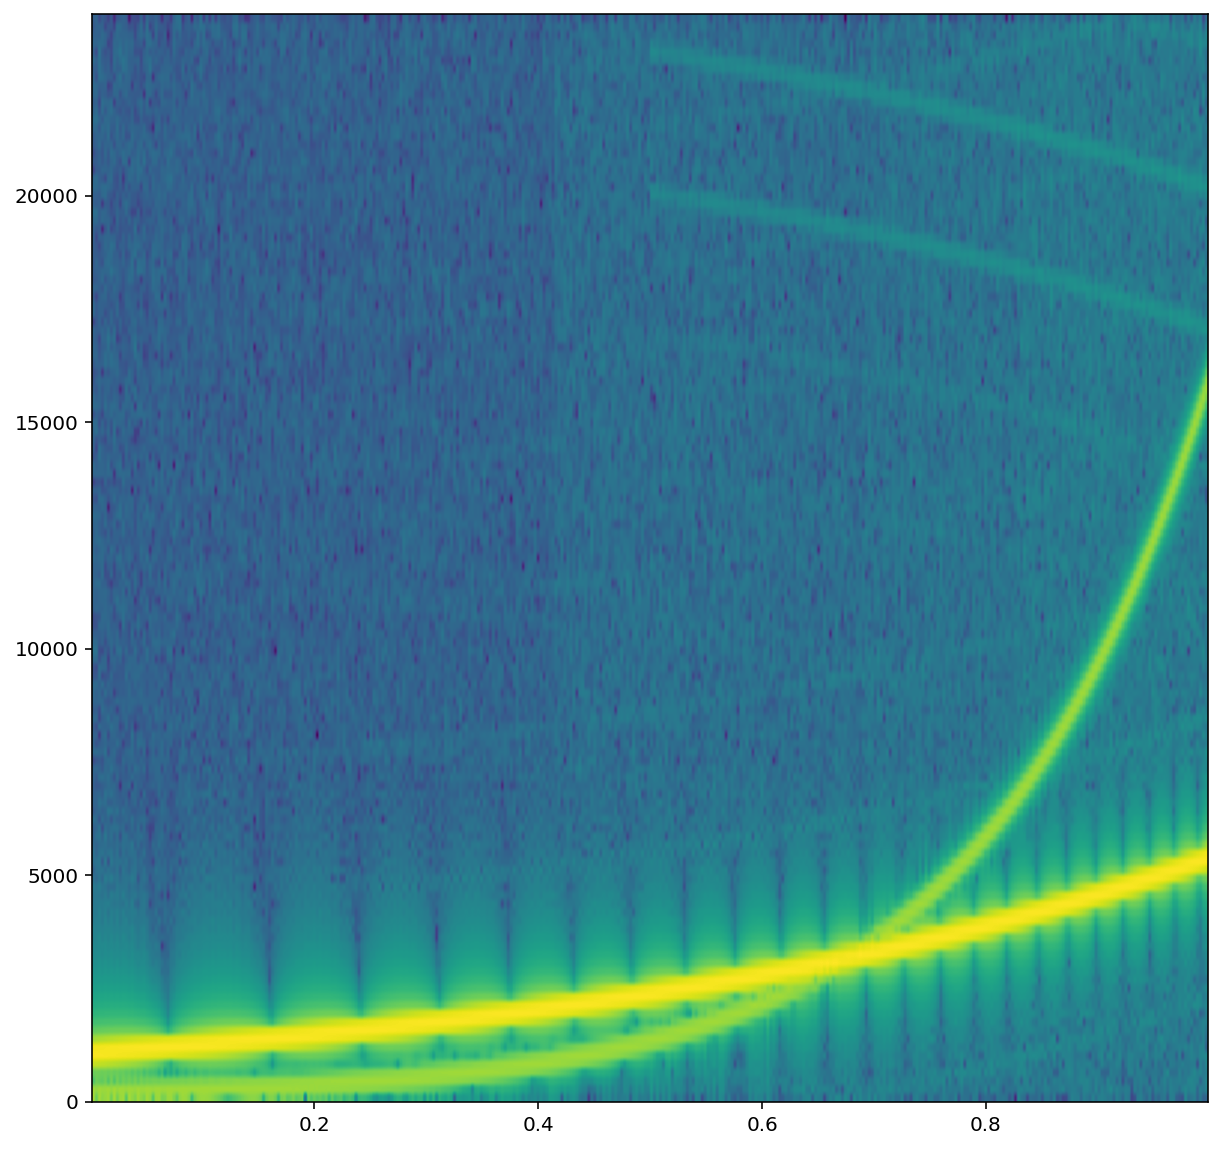

In [8]:
# @title Plot the matplotlib spectrogram

f0_0 = 1000
f1_0 = sample_rate / 9
e_0 = -10
f0_1 = 100
f1_1 = sample_rate / 3
e_1 = -20
two_chirps = signal.Signal(
    sample_rate=sample_rate,
    samples=(
        10 ** (e_0 * 0.1)
        * scipy.signal.chirp(
            chirp_sample_times, f0_0, t1, f1_0, method='logarithmic', phi=90
        )
        + 10 ** (e_1 * 0.1)
        * scipy.signal.chirp(
            chirp_sample_times, f0_1, t1, f1_1, method='logarithmic', phi=90
        )
    ),
)

plt.figure(figsize=(10, 10))
plt.specgram(two_chirps.samples, Fs=sample_rate)
plt.show()


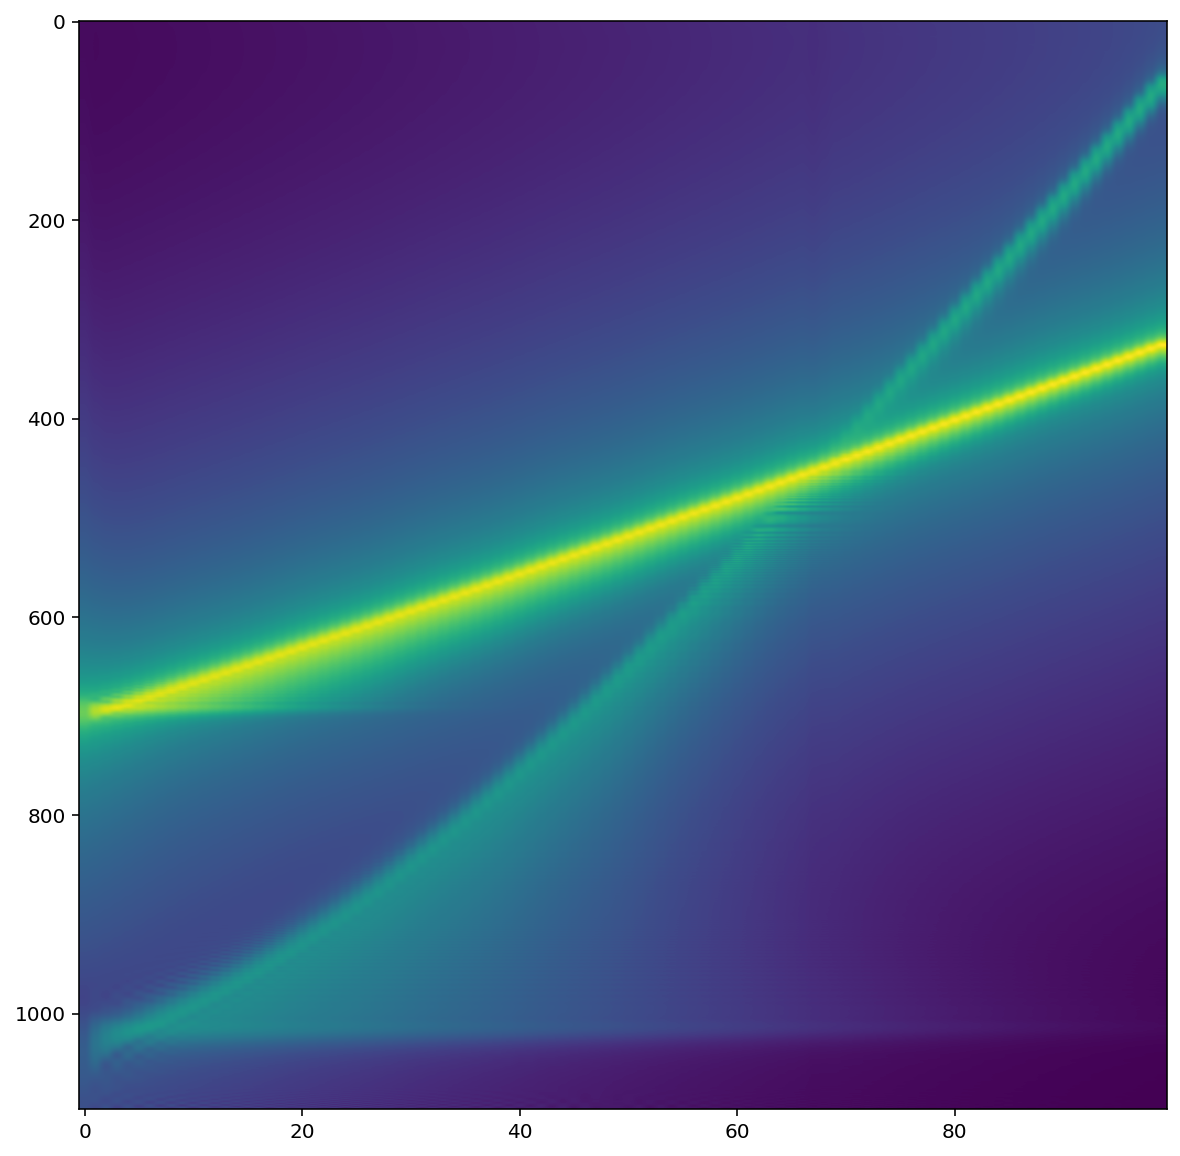

In [9]:
#@title Plot the Zimtohrli energy spectrogram


two_chirp_c = cam.Cam()
two_chirp_channels = two_chirp_c.channel_filter(two_chirps)
energy = two_chirp_channels.energy().to_db()

plt.figure(figsize=(10, 10))
plt.imshow(jnp.flip(energy.samples, axis=0), aspect=energy.samples.shape[1] / energy.samples.shape[0])
plt.show()

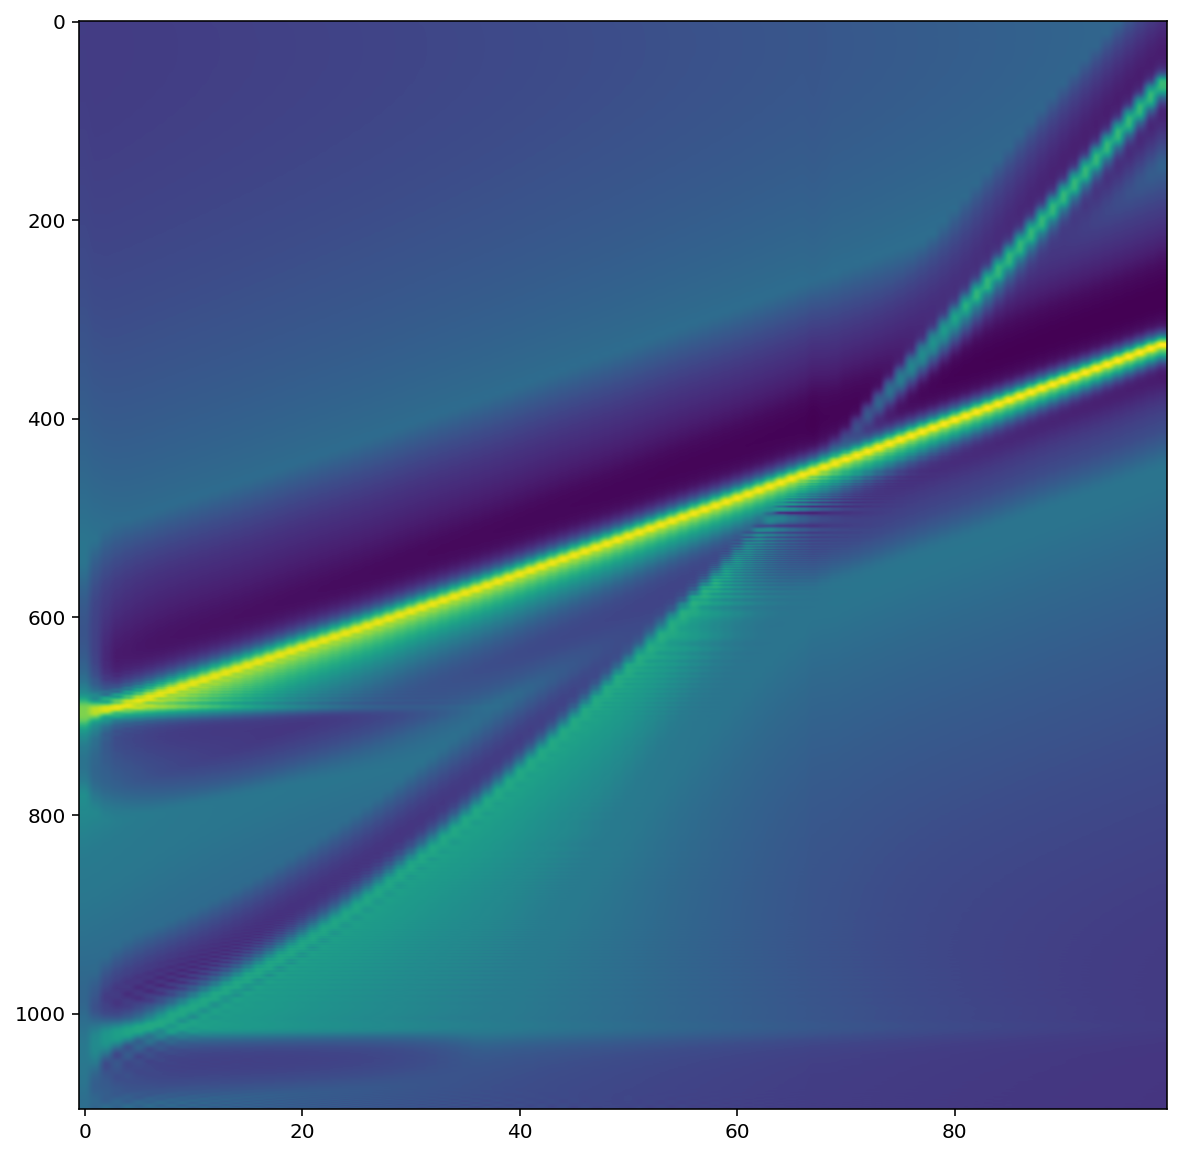

In [10]:
#@title Plot the Zimtohrli partial energy (post masking) spectrogram {display-mode: "form"}


m = masking.Masking()
partial_energy = m.partial_loudness(energy)
plt.figure(figsize=(10, 10))
plt.imshow(jnp.flip(partial_energy.samples, axis=0), aspect=partial_energy.samples.shape[1] / partial_energy.samples.shape[0])
plt.show()

It can be observed how the two chirps mask a certain amount of spectrum around them in the frequency domain, mostly higher frequencies, as well as a certain amount before and after them (due to filter insensitivity and ringing).

Conceptually this matches human hearing masking, in particular simultaneous masking and in a more limited way forward temporal masking.

More tuning of the parameters from listening test training data is expected to improve the match with subjective human hearing.

## Loudness model

After having computed partial dB for all channels in the sound, a loudness model based on ISO 226 (see e.g. https://en.wikipedia.org/wiki/Equal-loudness_contour) is applied to weigh the different spectrums and energy levels according to human sensitivity to sound energy.

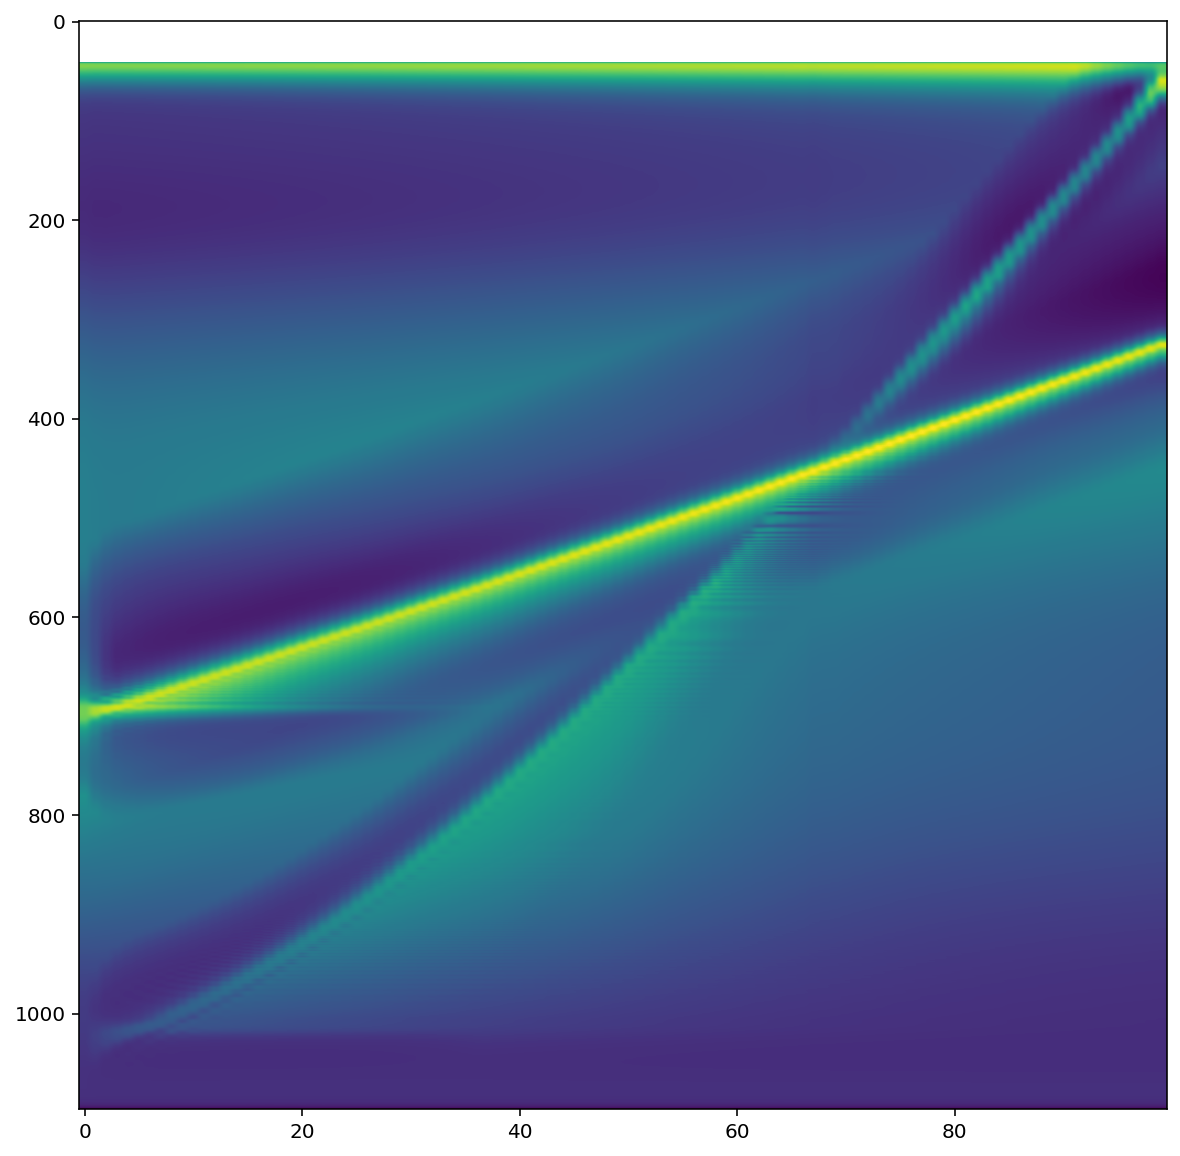

In [11]:
#@title Plot the Zimtohrli loudness (post loudness model) spectrogram {display-mode: "form"}


l = loudness.Loudness()
partial_loudness = l.phons_from_spl_for_channels(partial_energy)
plt.figure(figsize=(10, 10))
plt.imshow(jnp.flip(partial_loudness.samples, axis=0), aspect=partial_loudness.samples.shape[1] / partial_loudness.samples.shape[0])
plt.show()

# Final scoring

The final Zimtohrli distance metric is computed as a norm-of-norms, where a 4-norm is computed first of all frequency-channel-bins for each time step of the 100 Hz spectrogram, and then a final 4-norm is computed of the results.
